In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import sys

In [5]:
sys.path.append('..')

In [6]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay
)

In [7]:
from sklearn import set_config
set_config(display='diagram')

In [8]:
from this_project.censusdata import fetch_censusdata

In [9]:
X, y = fetch_censusdata()

In [10]:
X

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States


In [29]:
X['f1'] = X[['occupation','race']].apply(lambda x: x[0].strip() + '-' + x[1].strip(), axis=1)
X['f2'] = X[['occupation','sex']].apply(lambda x: x[0].strip() + '-' + x[1].strip(), axis=1)
X['f3'] = X[['race','sex']].apply(lambda x: x[0].strip() + '-' + x[1].strip(), axis=1)

In [30]:
NUM_COLS = [
    'age',
    'fnlwgt',
    'capital_gain',
    'capital_loss',
    'hours_per_week'
]

In [31]:
CAT_COLS = [
    'workclass',
    'education',
    'marital_status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native_country',
    
    'f1',
    'f2',
    'f3'
]

In [32]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
#     ('imputer', SimpleImputer(strategy='constant', fill_value=0.0))
])

categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUM_COLS),
        ('cat', categorical_transformer, CAT_COLS)])

In [33]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', MLPClassifier(hidden_layer_sizes=(60,)))])
                      ('classifier', LogisticRegression(C=100., max_iter=1000, class_weight='balanced', random_state=0))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.805


In [34]:
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'capital_gain',
                                                   'capital_loss',
                                                   'hours_per_week']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'education',
                                                   'marital_status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native_country', 'f1', 'f2',
                                                   'f3'])])),
                ('classifier',
                 LogisticRegression(C=100.0, class_weight='balanced',
                                    max_iter=1000, random_state=0))])

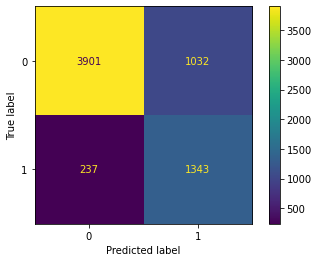

In [35]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

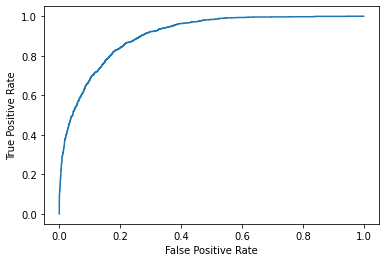

In [36]:
y_score = clf.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

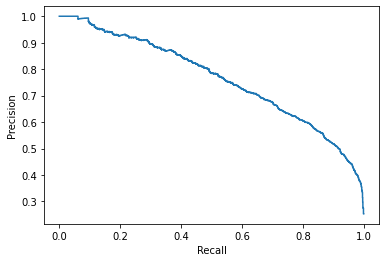

In [37]:
prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()